## Repairing artifacts with ICA
ICA(Independent components analysis)를 이용하여 다양한 노이즈(눈 깜빡임 등등)를 제거해 보자!  
  
Tutorial과 동일한 sample data 사용  

*꼭 ICA만 쓰는게 아니라, 데이터에 알맞는 artifact removal tool을 사용하세요!!

In [1]:
import os

import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.0).pick(picks=["mag", "eeg", "stim", "eog"])
raw.load_data()

Opening raw data file C:\Users\NMAIL\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 172 x 9010 (60.0 s), ~14.9 MB, data loaded>

### What is ICA?
여러 가지 독립적인 source signal들이 알 수 없는 비율로 합쳐져(섞여) 있을 때 각 독립적인 source signal들을 분리해 내는 계산 방법  
  
EEG/MEG 데이터 역시 여러 개의 채널을 통해 데이터를 기록하고, 각 데이터는 여러 가지 독립적인 신호들(눈 깜빡임에 의한 신호, 심장 박동, 실제 뇌파 등...)로 이루어져 있으며, 각 신호들은 통계적으로 독립이며 non-gaussian이라 ICA를 통한 구분이 가능하다. 

Example : EOG and ECG artifact repair  
artifact를 일단 시각화해보자

Using matplotlib as 2D backend.


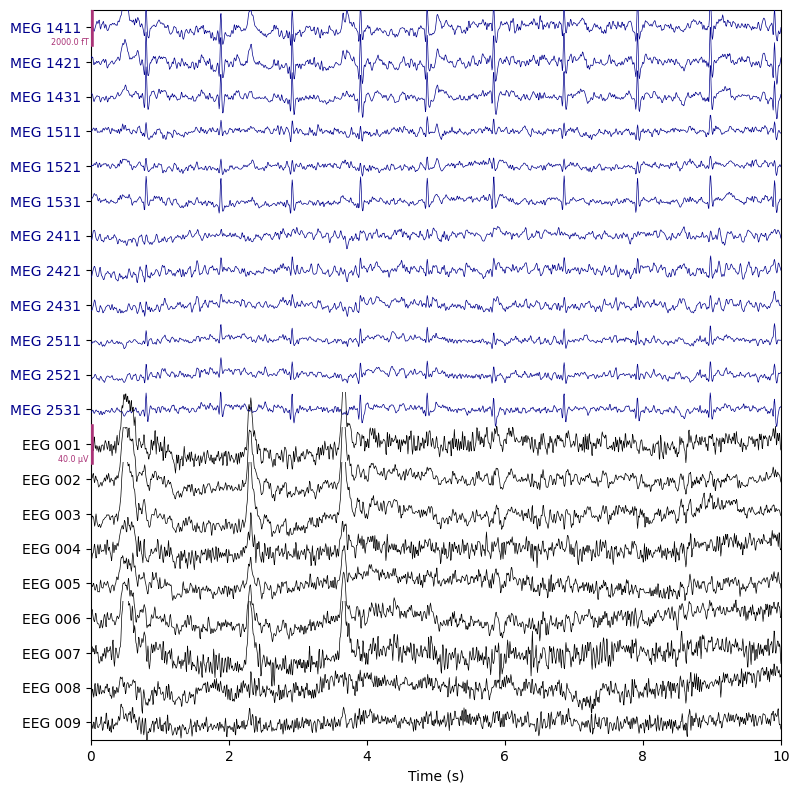

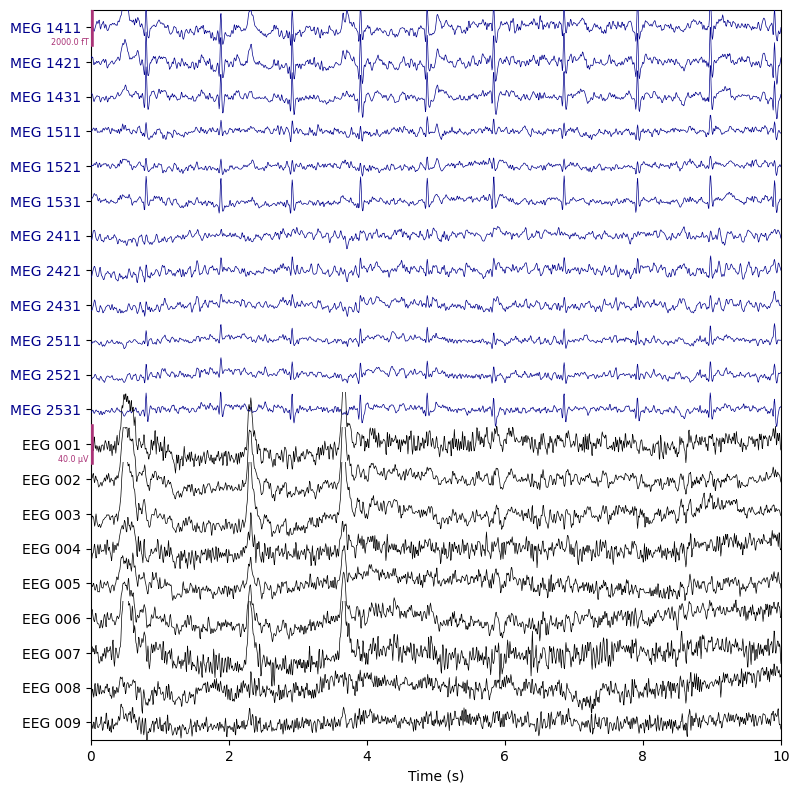

In [2]:
# pick some channels that clearly show heartbeats and blinks
regexp = r"(MEG [12][45][123]1|EEG 00.)"
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

깜빡 깜빡이 잘 보인다

*EOG (electrooculography) : 안전도  
  
create_eog_epochs 메서드를 통해 이러한 눈 움직임에 의한 artifact가 어떻게 나타는지 쉽게 확인할 수 있다

Using EOG channel: EOG 061
EOG channel index for this subject is: [171]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 10 events and 151 original time points 

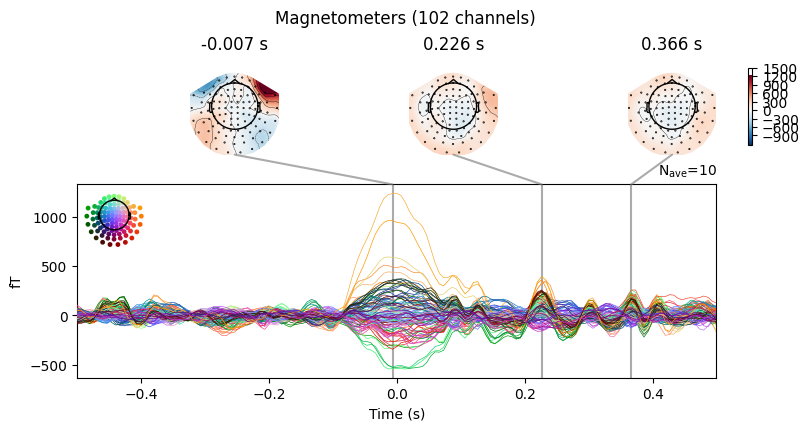

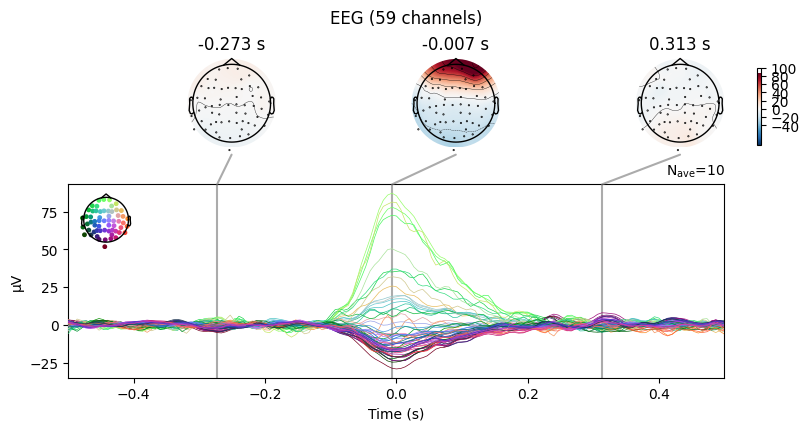

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [4]:
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

마찬가지로 심장박동에 대해서도 create_ecg_epochs를 이용 가능

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 s)

Number of ECG events detected : 59 (average pulse 58.99492412402019 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 59 events and 151 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...


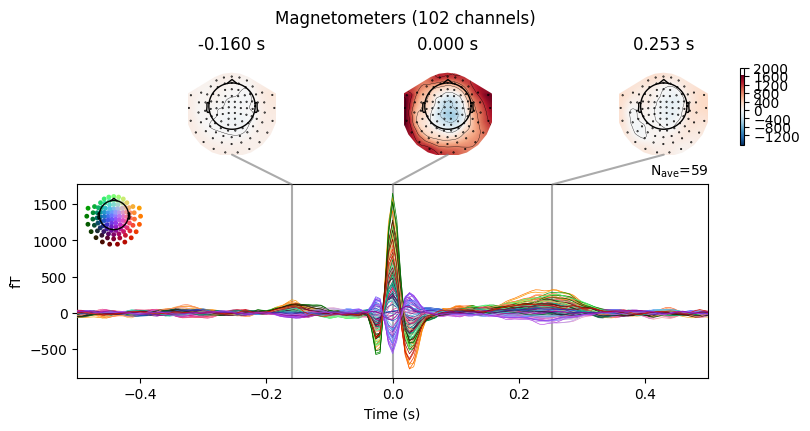

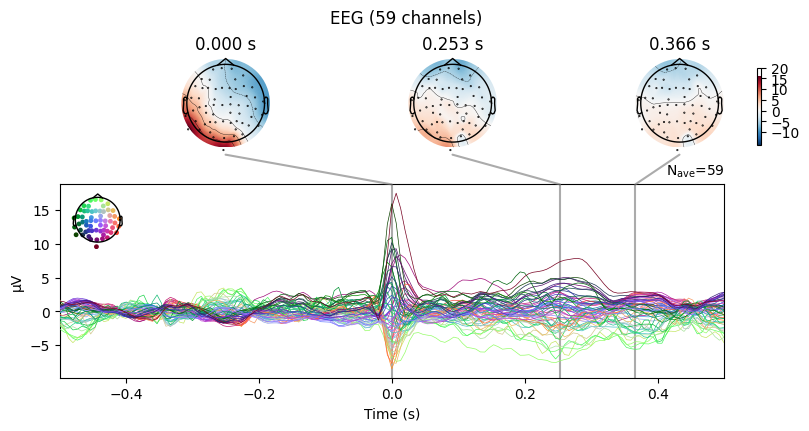

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [5]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline = (None, -0.2))
ecg_evoked.plot_joint()

#### Filtering to remove slow drifts
저주파 쪽으로 slow drift(신호가 전반적으로 점차 상승/하강하는 경향)이 일어나는 걸 막기 위해 필터링을 해줘야 한다  
slow drift를 그대로 두면 뇌파, 심박 등의 신호 값이 점진적으로 커지게 되고 이는 각 source signal들의 독립성을 낮추어 알고리즘이 정확한 ICA를 해내지 못하게 만든다  
  
여기서는 1Hz를 threshold로 필터링하며, 필터링은 선형 연산이기 때문에 필터링을 하고 나서 ICA를 적용한 결과를 필터링 안 한 raw data에도 그대로 적용할 수 있다  
그러니 일단 raw data를 삭제하지 않고, 복제본에 대해 필터링을 진행하자

In [6]:
filt_raw = raw.copy().filter(l_freq = 1.0, h_freq = None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


#### Fitting ICA
  
이제 ICA를 적용시켜 보자!!  
  
(이 데이터에서) EOG, ECG(안전도, 심박)가 꽤 강하게 나타난다는 걸 알고 있기 때문에 ICA를 하기 전에 이미 PCA decomposition에서 처음 몇 차원만으로 이런 artifact들을 어느 정도 포착해낼 수 있다는 것을 예상할 수 있다.  
  
따라서 ICA를 할 때 component를 너무 많이 설정할 필요가 없으며, 빠른 실행과 쉬운 분석을 위해 우선 15로 설정하자(데이터 기록한 채널 수가 300개임을 감안하면 엄청 작은 수다!!)

In [7]:
ica = ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.1s.


<ICA | raw data decomposition, method: fastica (fit in 22 iterations on 9010 samples), 15 ICA components (161 PCA components available), channel types: mag, eeg, no sources marked for exclusion>

#### Looking at the ICA solution
이제 ICA를 해서 나온 결과를 잘 살펴보자  
  
get_explained_variance_ratio() 메서드를 통해 원본 데이터에서 각각 분산의 비율을 얻어낼 수 있다(딕셔너리 형태로 제공)

In [8]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of mag variance explained by all components: 0.9358001342790973
Fraction of eeg variance explained by all components: 0.7798689203334388


아래와 같이 component와 channel type을 특정해서 물어볼 수도 있음

In [9]:
explained_var_ratio = ica.get_explained_variance_ratio(
    filt_raw, components=[0], ch_type = "eeg"
)
#This time, print as percentage
ratio_percent = round(100*explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component : "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component : 33%


plot_sources() 하면 각 IC(Independent component) signal들을 시계열로 그려 준다.   
여기서는 필터링 전 원래의 raw 데이터의 ICA 결과를 표시하자

Creating RawArray with float64 data, n_channels=16, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


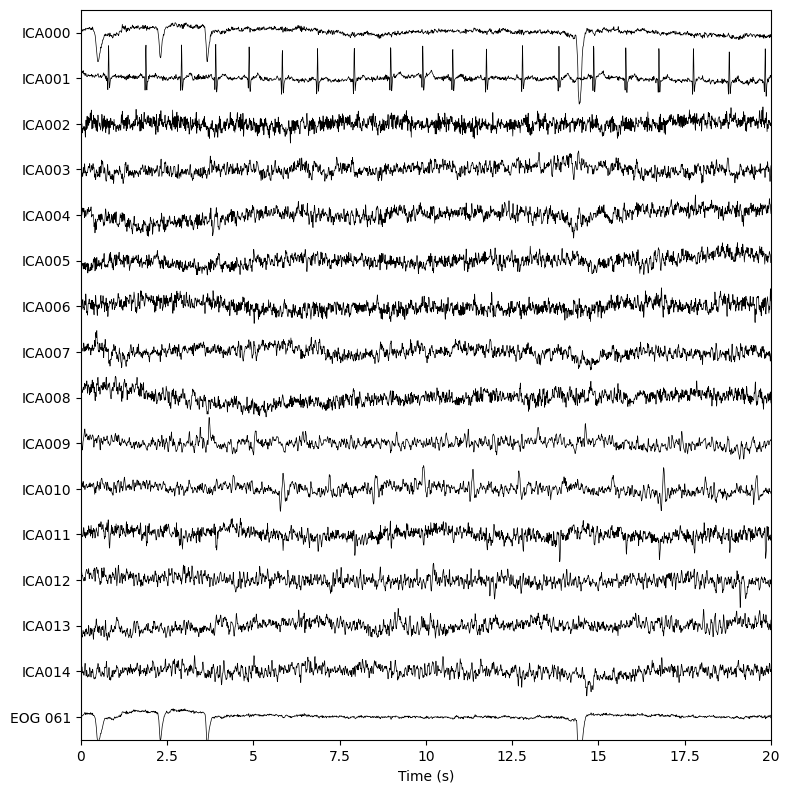

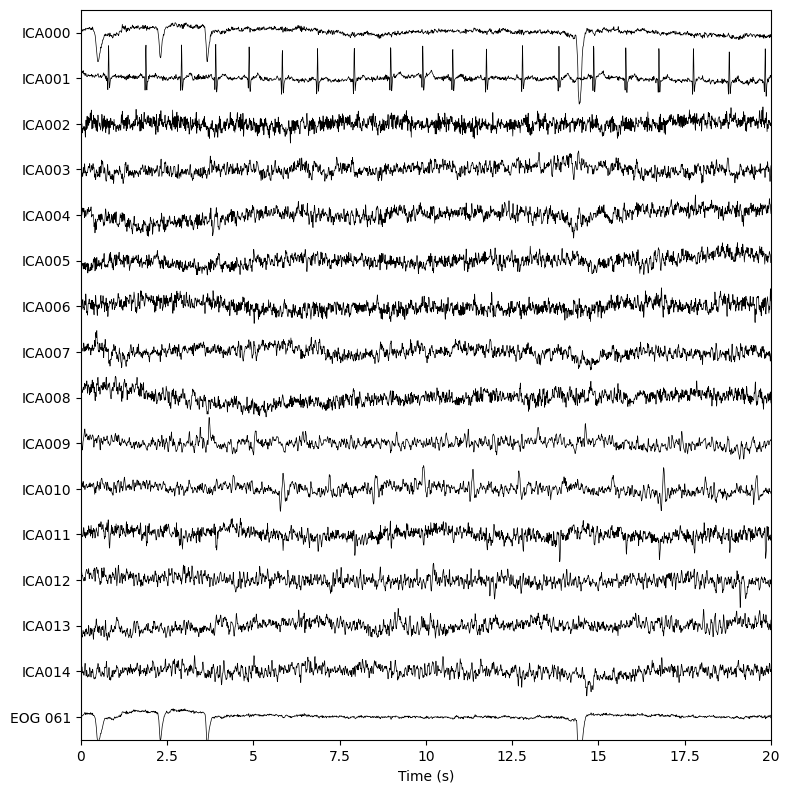

In [10]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

이렇게 시계열 그래프를 그려 놓고 보면 ICA000이 눈 깜빡임(EOG), ICA001이 심박을 나타낸다는 것을 확인할 수 있다.  
plot_components() 메서드로 각 component별 scalp field distribution도 시각화해보자

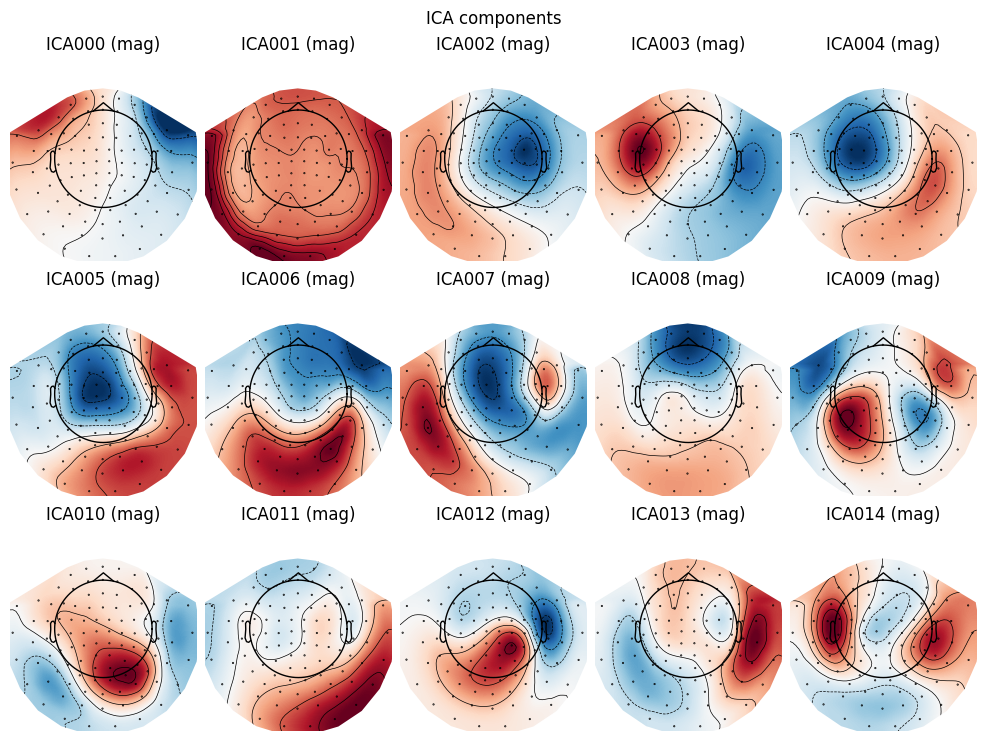

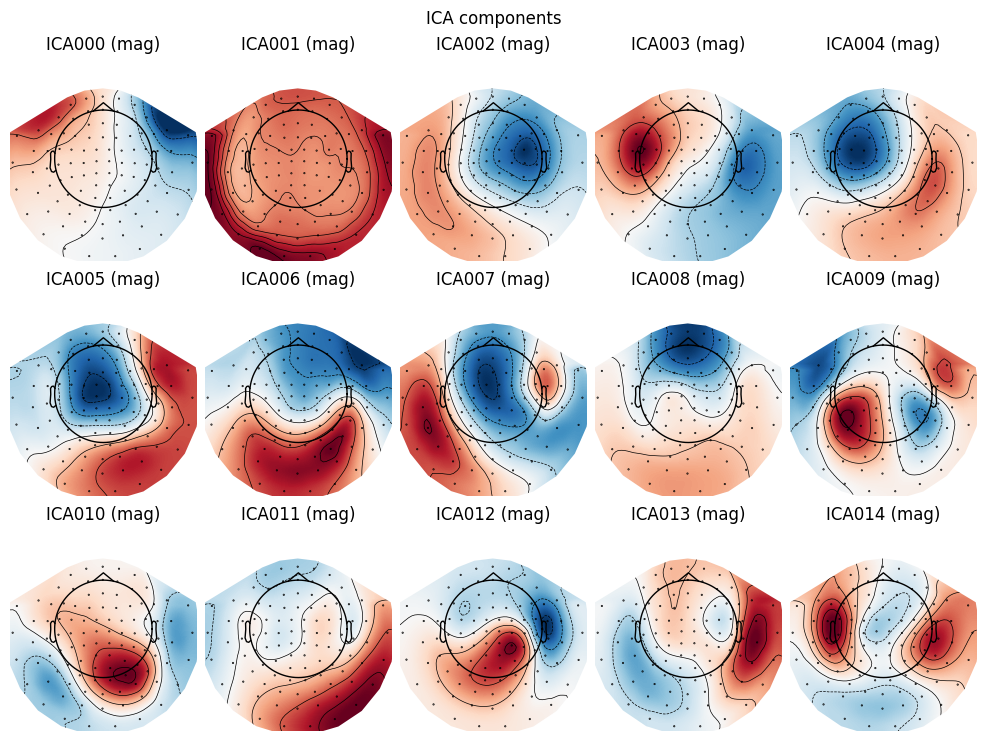

In [11]:
ica.plot_components()

더 확실히 하기 위해 plot_overlay()를 통해 원래의 신호와 artifactual IC를 제거한 신호를 겹쳐서 그려 볼 수 있다

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 161 PCA components


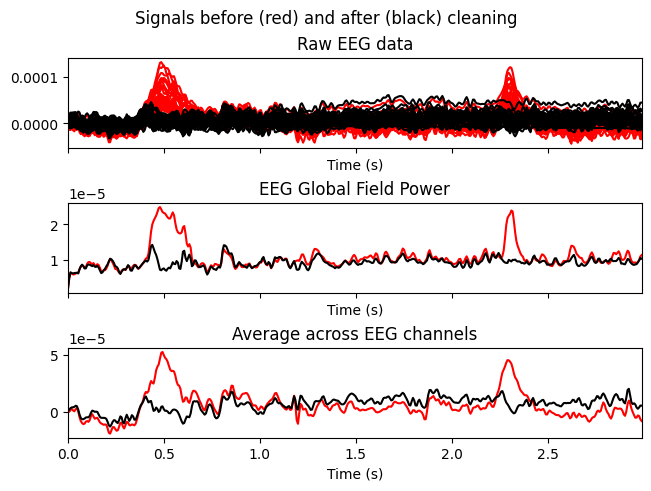

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 161 PCA components


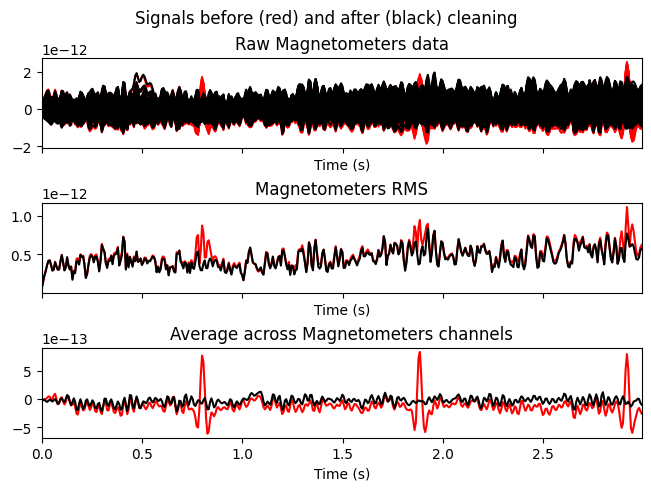

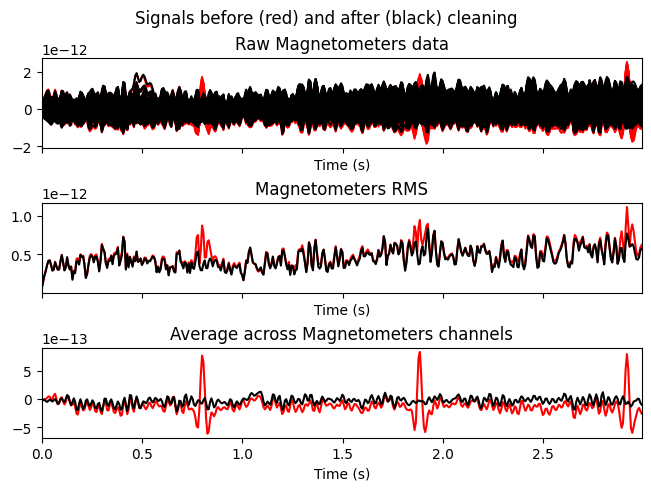

In [13]:
#blinks
ica.plot_overlay(raw, exclude=[0], picks="eeg")
#heartbeats
ica.plot_overlay(raw, exclude=[1], picks="mag")

plot_properties()를 통해 각 IC의 정보를 표시할 수 있다

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


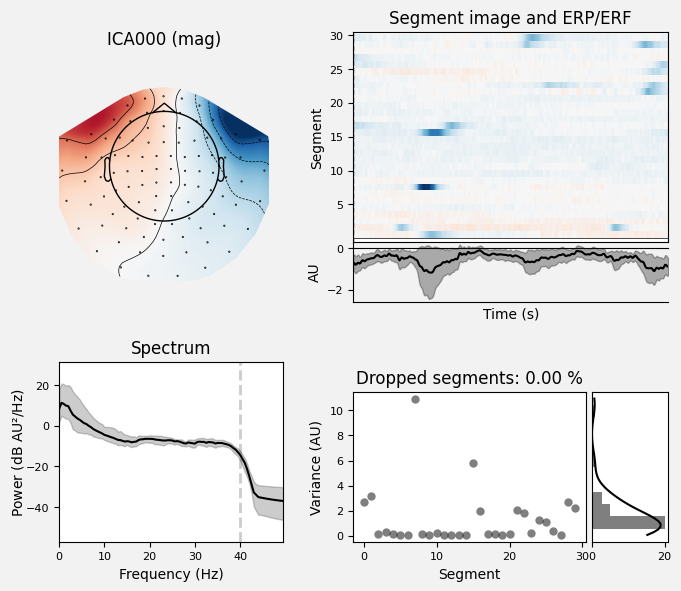

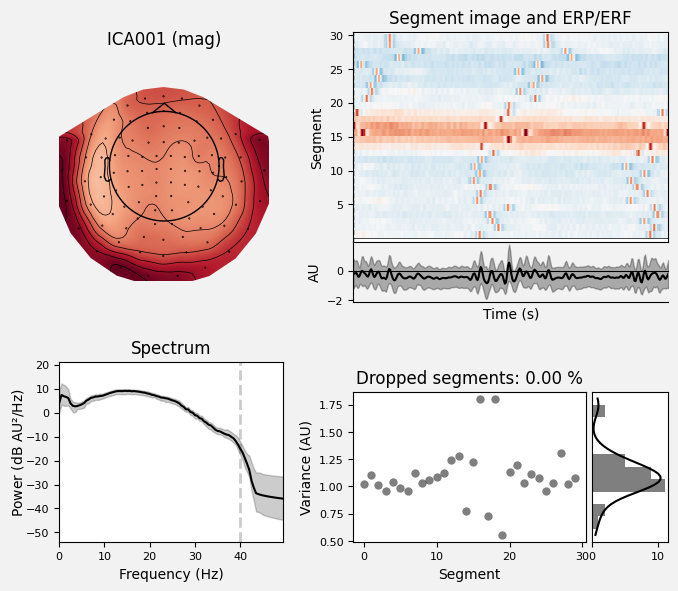

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [14]:
ica.plot_properties(raw, picks=[0,1])

아무튼 확실히 ICA000, ICA001 컴포넌트는 제외해야 한다는 걸 알았다!!!

#### Selecting ICA components manually  
ica.exclude를 통해 제외할 컴포넌트를 설정할 수 있다  
이렇게 설정하고 나면 plot_overlay 같은 다른 메서드들을 실행할 때 exclude 파라미터 없이도 자동으로 이걸 반영해 준다.  
제외된 컴포넌트들은 mne.preprocessing.ICA.save나 mne.preprocessing.read_ica를 쓸 때는 보존된다.

In [15]:
ica.exclude=[0,1]

apply 메서드를 통해 artifact가 제거된 sensor signal을 reconstruct할 수 있다

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 161 PCA components


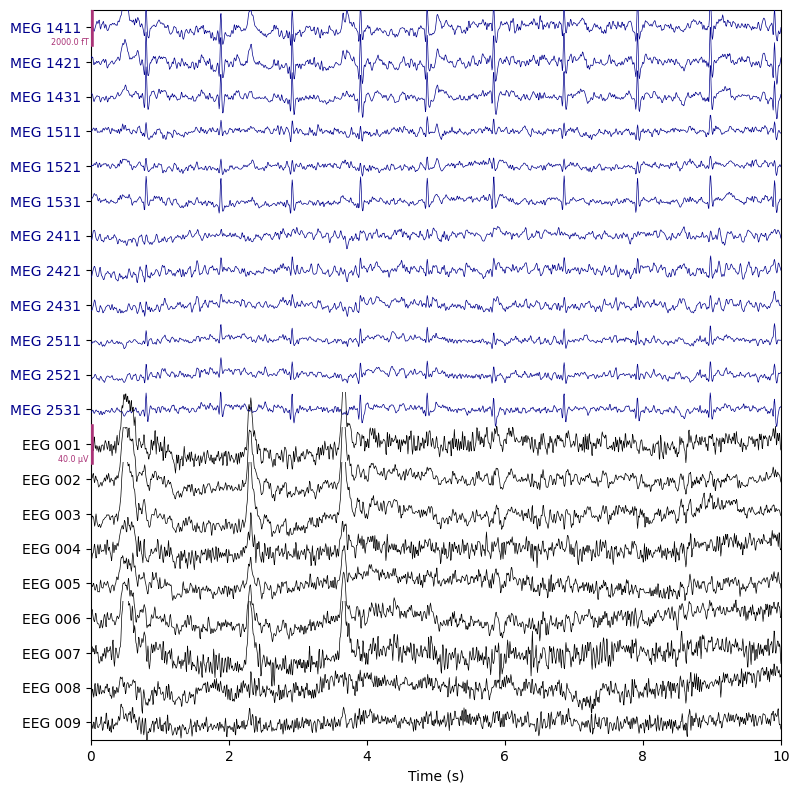

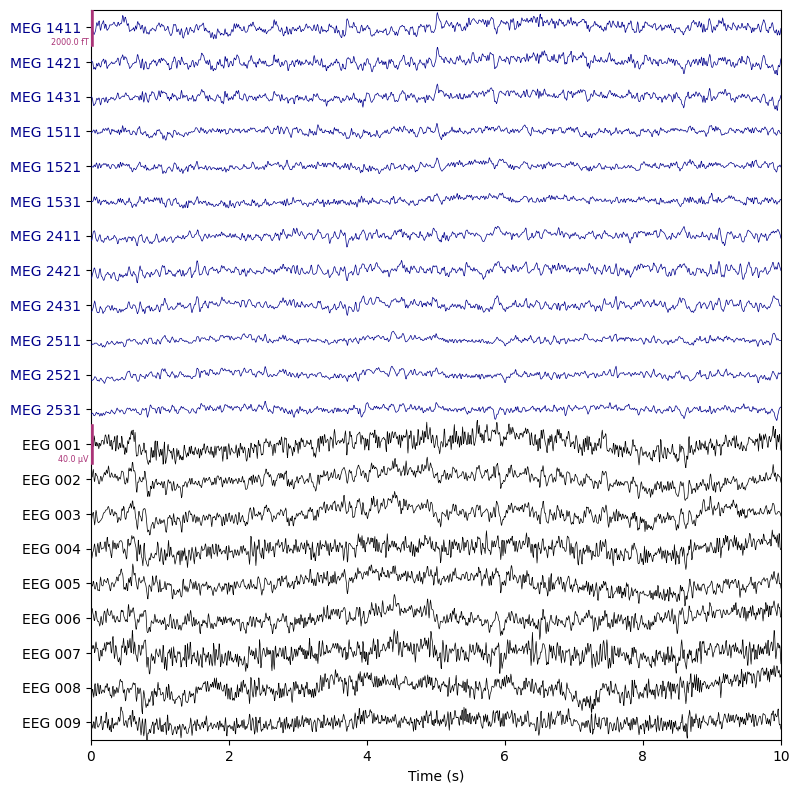

In [16]:
#ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot(order=artifact_picks, n_channels = len(artifact_picks), show_scrollbars=False)
reconst_raw.plot(
    order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)
del reconst_raw

훨씬 깔끔하네~

#### Using an EOG channel to select ICA components  
artifact에 해당하는 component를 찾는게 쉬워 보였지만 데이터의 크기가 커지면 직접 육안으로 확인하고 선택하는게 별로 쉽지 않다.  